# Regression Project2 - RDD


### Requirements: 

#### A - find data on * at least * one COVID measure for y:

either:

    1 - COVID cases
    2 - hospitalizations
    3 - deaths
#### B - Use RDD to estimate the effect of the following events in Quebec:

- D1. 20/3/2020 - lockdown

- D2. 31/8/2020 - The reopening of schools 

- D3. 25/12/2020 - lockdown

#### C - provide the following for each:

- c.1) A RDD plot similar to the ones shown above

- c.2) An interpretation of the p-value on the effect of the measure taken (the cutoff parameter)

- c.3) A justification on the design of your regression:

       The amount of time included on both sides of the cutoff (longer is not necessarily better)

       The polynomial degree (higher is not always better)

       Other regression design considerations

- c.4) A 2 paragraph explanation of your findings for that event.

#### Data Sources:
    https://www.donneesquebec.ca/recherche/dataset/covid-19-portrait-quotidien-des-cas-confirmes
    https://www.inspq.qc.ca/covid-19/donnees

    https://www.inspq.qc.ca/sites/default/files/covid/donnees/covid19-hist.csv
    the columns explained  https://github.com/SimonCoulombe/covidtwitterbot
    
    https://ourworldindata.org/explorers/coronavirus-data-explorer?zoomToSelection=true&time=2020-03-01..latest&facet=none&pickerSort=asc&pickerMetric=location&Metric=Hospital+patients&Interval=7-day+rolling+average&Relative+to+Population=true&Color+by+test+positivity=false&country=~CAN
    https://health-infobase.canada.ca/covid-19/#a3
    https://health-infobase.canada.ca/src/data/covidLive/covid19-download.csv

In [2]:
import os
import matplotlib.pyplot as plt 
import numpy as np 
from statsmodels.formula.api import ols
import pandas as pd
from patsy import dmatrices
import scipy.stats as sc
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import seaborn as sns 
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge

import scipy.stats
import scipy.special

from sklearn.model_selection import train_test_split

sns.set()

####  DATAFRAMES

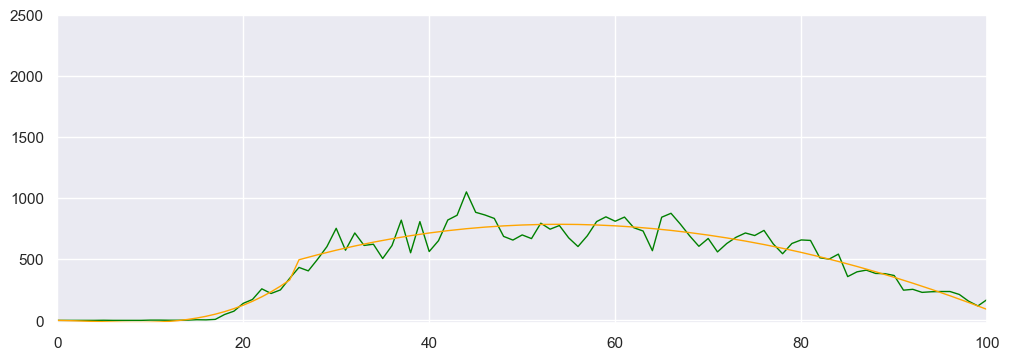

In [117]:
# os.getcwd()

#    - COVID CASES -
df_cov = pd.read_csv('data/graph_1-1_page_par_region.csv')
df_cov

#    - HOSPITALIZATIONS -
df_hosp = pd.read_csv('data/graph_3-1_page_par_region.csv')
#df_hosp

#    - DEATH -
df_death = pd.read_csv('https://msss.gouv.qc.ca/professionnels/statistiques/documents/covid19/COVID19_Qc_RapportINSPQ_HistoVigie.csv')
#df_death = pd.read_csv('https://msss.gouv.qc.ca/professionnels/statistiques/documents/covid19/COVID19_Qc_RapportINSPQ_VigieCategories.csv')
#df_death = pd.read_csv('https://health-infobase.canada.ca/src/data/covidLive/covid19-download.csv')
#df_death

df_cov.rename({'Date de résultat du test':'Date','Cas confirmés':'Cases'},axis=1,inplace=True)
df_cov['Date']=pd.to_datetime(df_cov['Date'])
df_cov
df_hosp.rename({'Date d\'admission':'Date','Hors soins intensifs':'Not Intensive','Aux soins intensifs':'Intensive'},axis=1,inplace=True)

df_hosp['Date']=pd.to_datetime(df_cov['Date'])
df_hosp['Hospital']=df_hosp['Not Intensive']+df_hosp['Intensive']



fig,ax1=plt.subplots(1,1,figsize=(12,4))

from datetime import datetime
dates=[
    datetime.strptime('20200320','%Y%m%d'),
    datetime.strptime('20200831','%Y%m%d'),
    datetime.strptime('20201225','%Y%m%d')
]
start=datetime.strptime('20200301','%Y%m%d')
end=datetime.strptime('20210301','%Y%m%d')

dates_ordinal=[datetime.toordinal(x) for x in dates]
start_ordinal=datetime.toordinal(start)
end_ordinal=datetime.toordinal(end)-start_ordinal

df_cov=df_cov.loc[df_cov['Date']<end]
df_hosp=df_hosp.loc[df_hosp['Date']<end]

symptoms=pd.DateOffset(days=5.6)

df_hosp['Date']=df_hosp['Date'].map(datetime.toordinal)-start_ordinal
df_cov['Date']=df_cov['Date'].map(datetime.toordinal)-start_ordinal

df_cov['Lockdown']=(df_cov['Date']>dates_ordinal[0]-start_ordinal+6).astype(int)

# for i in dates:
#     print(i)
#     ax1.plot([i,i],[0,2000],c='black',alpha=1.0,linewidth=0.5)
#     ax1.plot([i+symptoms,i+symptoms],[0,2000],c='#F80',alpha=1.0,linewidth=0.5)

# df_cov['Date']=(df_cov['Date']-pd.Timestamp("1970-01-01"))//pd.Timedelta("1s")
# df_hosp['Date']=(df_hosp['Date']-pd.Timestamp("1970-01-01"))//pd.Timedelta("1s")


# df_cov['Date']-=737000

df_hosp=df_hosp.dropna()

ax1.plot(df_cov['Date'],df_cov['Cases'],c='green',alpha=1.0,linewidth=1.0,label='cases')
# ax1.plot(df_hosp['Date'],df_hosp['Hospital'],c='red',alpha=1.0,linewidth=1.0,label='cases')

df_cov['c2']=1

model=ols('''Cases ~ 

Date + I(Date**2) + I(Date**3) + 

Date*Lockdown + I(Date**2)*Lockdown + I(Date**3)*Lockdown

-1

''',data=df_cov.loc[df_cov['Date']<100]).fit()
ax1.plot(df_cov['Date'],model.predict(df_cov),c='orange',alpha=1.0,linewidth=1.0,label='cases')

ax1.set_xlim(0,100)
ax1.set_ylim(-20,2500)
plt.show()


In [111]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     127.1
Date:                Wed, 22 Feb 2023   Prob (F-statistic):           2.50e-34
Time:                        11:25:29   Log-Likelihood:                -676.38
No. Observations:                 106   AIC:                             1361.
Df Residuals:                     102   BIC:                             1371.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -21.1809     36.945     -0.573      0.568     -94.461      52.099
Date              7.2625      2.789      2.604      0.011       1.731      12.794
Lockdown        967.4238     64.081     15.097      0.000     840.320    1094.527
Date:Lockdown   -12.7174      2.899     -4.386      0.000     -18.468      -6.967
==============================================================================
Omnibus:                        1.771   Durbin-Watson:                   0.534
Prob(Omnibus):                  0.413   Jarque-Bera (JB):                1.642
Skew:                          -0.302   Prob(JB):                        0.440
Kurtosis:                       2.921   Cond. No.                         378.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
# y,x=dmatrices('Cases ~ Date',df_cov)

# model=sm.OLS(y,x).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     152.0
Date:                Wed, 22 Feb 2023   Prob (F-statistic):           7.15e-16
Time:                        11:00:14   Log-Likelihood:                -289.78
No. Observations:                  46   AIC:                             583.6
Df Residuals:                      44   BIC:                             587.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.379e-16   1.12e-17    -12.330      0.000    -1.6e-16   -1.15e-16
Date         -6.779e-11    5.5e-12    -12.330      0.000   -7.89e-11   -5.67e-11
I(Date ** 2) -2.501e-05   2.03e-06    -12.330      0.000   -2.91e-05   -2.09e-05
I(Date ** 3)  3.391e-11   2.75e-12     12.330      0.000    2.84e-11    3.94e-11
==============================================================================
Omnibus:                        4.474   Durbin-Watson:                   0.413
Prob(Omnibus):                  0.107   Jarque-Bera (JB):                2.006
Skew:                           0.154   Prob(JB):                        0.367
Kurtosis:                       2.024   Cond. No.                     9.13e+31
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.87e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [29]:
#df.columns


## 1- COVID CASES

#### A- Dependances and Response definition

In [ ]:
# if a common df is used, use: df.copy()


In [20]:
x_cov =[['','',]]
y_cov =[['']]

#### B- RDD for D1. 20/3/2020 | D2. 31/8/2020 | D3. 25/12/2020 

#### C.1) PLOT

#### C.2) Interpretation of the p-value on the effect of the measure taken

#### C.3) Justification on the design of your regression

#### C.4)  paragraph explanation of your findings for that event.

### 2- HOSPITALIZATIONS

#### A- Dependances and Response definition

In [ ]:
# if a common df is used, use: df.copy()


#### B- RDD for D1. 20/3/2020 | D2. 31/8/2020 | D3. 25/12/2020

#### C.1) PLOT

#### C.2) Interpretation of the p-value on the effect of the measure taken

#### C.3) Justification on the design of your regression

#### C.4) paragraph explanation of your findings for that event.

### 3- DEATHS

#### A- Dependances and Response definition

In [ ]:
# if a common df is used, use: df.copy()


#### B- RDD for D1. 20/3/2020 | D2. 31/8/2020 | D3. 25/12/2020

#### C.1) PLOT

#### C.2) Interpretation of the p-value on the effect of the measure taken

#### C.3) Justification on the design of your regression

#### C.4)  paragraph explanation of your findings for that event.

# - CONCLUSION -
### A 2 paragraph explanation of your findings for that event.